### Importing libraries

In [14]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import preprocessing
from keras import datasets, layers, models
from sklearn.metrics import confusion_matrix

# Dataset Preprocessing

## function to populate the an array with images

In [15]:
# opens a directory with classes sorted into subdirectories, then populates the list of images and labels
def populate_set(dir: str):
    images = []
    labels = []
    # get subdirectory name and loop through it
    for category in os.listdir(dir):
        path = os.path.join(dir, category)
        # drop 9/10 items using variable
        drop = 0
        # get the file inside the subdirectory and loop through it
        for filename in os.listdir(path):
            # keep 1/10
            if ( drop == 0):
                # read the image and check if its valid
                img = cv.imread(os.path.join(path, filename))
                if img is not None:
                    img.resize(224,224,3)
                    # reverse the order of the colour scheme to be RGB
                    img = img[:,:, ::-1]
                    # add image
                    images.append(img)
                    # add label
                    labels.append(category)
            # increment drop
            # drop = (drop + 1) % 20      #**Can change to use more or less of dataset**
    return np.array(images), np.array(labels, dtype=str)

# checks all the subdirectories which are labeled and returns a list of classes
def get_categories(dir: str):
    categories = []
    # get subdirectory name and loop through it
    for category in os.listdir(dir):
        categories.append(category)
    return categories      

## Populate the arrays with image information

In [16]:
# Get the relative directory for training and test data
valid_dir = "../imgs/validation"
train_dir = "../imgs/train"
test_dir = "../imgs/test"

# Since the dataset is super large, we will use 10% due to the limits of my PC
# NOTE: ideally use the entire dataset for best results

# get training data
train_img, train_lab = populate_set(train_dir)

# get validation data
valid_img, valid_lab = populate_set(valid_dir)

# get testing data
test_img, test_lab = populate_set(test_dir)

# get list of categories
categories = get_categories(train_dir)

### Normalize and reorder data

In [17]:
# normalize the dataset
train_img, test_img = train_img/255 , test_img/255

# for consistency in testing output
np.random.seed(seed=0)

# shuffle the index order; make the dataset less organized
train_indx = np.random.permutation(train_img.shape[0])
test_indx = np.random.permutation(test_img.shape[0])

# shuffle training data
train_img = train_img[train_indx]
train_lab = train_lab[train_indx]

# shuffle testing data
test_img = test_img[test_indx]
test_lab = test_lab[test_indx]


## Displaying images and their labels from training set

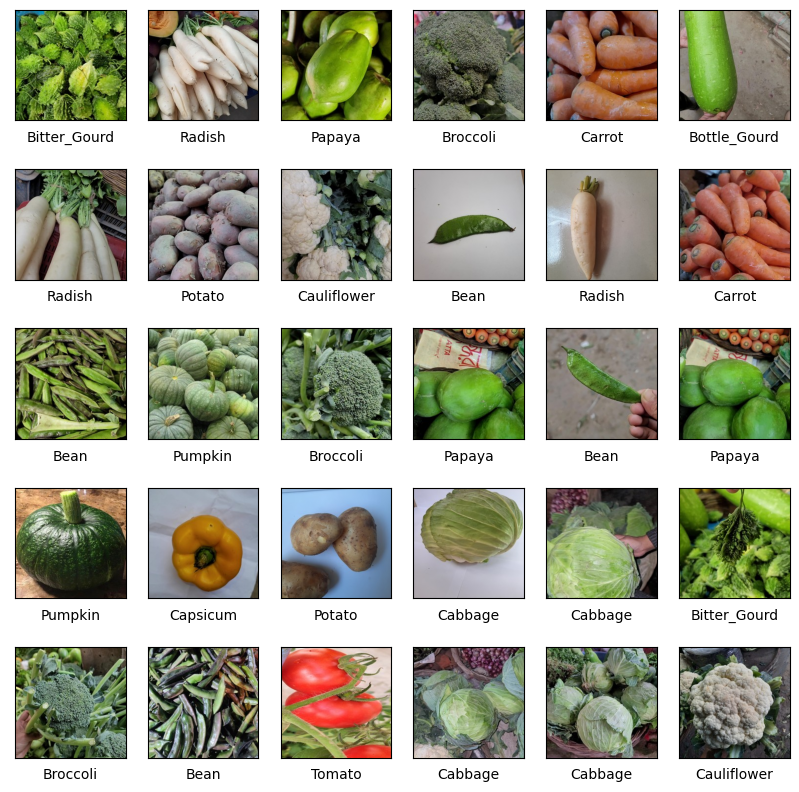

In [18]:
# set each figure to be 10x10
plt.figure(figsize=(10,10))

# show the training dataset
for i in range(30):
    # create a subplot for 30 sections
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # display the image
    plt.imshow(train_img[i])
    # display the label
    plt.xlabel(train_lab[i])

# display the dataset inside
plt.show()

In [19]:
# Convert all the labels to integers
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(categories)

# Encode the training into one_hot scheme
train_lab = label_encoder.transform(train_lab)
train_one_hot = tf.one_hot(train_lab, 15)

# Encode the validation set into one_hot scheme
valid_lab = label_encoder.transform(valid_lab)
valid_one_hot = tf.one_hot(valid_lab, 15)

# Encode the integers into one_hot scheme
test_lab = label_encoder.transform(test_lab)
test_one_hot = tf.one_hot(test_lab, 15)


# Create Neural Network Model

In [20]:
# Layer architecture will be sequential

model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [21]:
# configure the model for training
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model and save the history of training
history = model.fit(train_img, train_one_hot,
                    validation_data=(valid_img, valid_one_hot),
                    epochs=10)

Epoch 1/10
469/469 [==============================] - 318s 674ms/step - loss: 1.2048 - accuracy: 0.6210 - val_loss: 238.0942 - val_accuracy: 0.5600
Epoch 2/10
469/469 [==============================] - 321s 684ms/step - loss: 0.2980 - accuracy: 0.9105 - val_loss: 209.6101 - val_accuracy: 0.6403
Epoch 3/10
469/469 [==============================] - 319s 680ms/step - loss: 0.1022 - accuracy: 0.9721 - val_loss: 284.7670 - val_accuracy: 0.6823
Epoch 4/10
469/469 [==============================] - 322s 687ms/step - loss: 0.0484 - accuracy: 0.9877 - val_loss: 349.3743 - val_accuracy: 0.6757
Epoch 5/10
469/469 [==============================] - 315s 672ms/step - loss: 0.0507 - accuracy: 0.9854 - val_loss: 338.1649 - val_accuracy: 0.6847
Epoch 6/10
469/469 [==============================] - 316s 673ms/step - loss: 0.0286 - accuracy: 0.9923 - val_loss: 370.2577 - val_accuracy: 0.6810
Epoch 7/10
469/469 [==============================] - 313s 668ms/step - loss: 0.0359 - accuracy: 0.9895 - val_lo

## Graphically show the training performance

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2036\2807844708.py:11: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0][1].get_shared_y_axes().join(axs[0][1], axs[0][0])


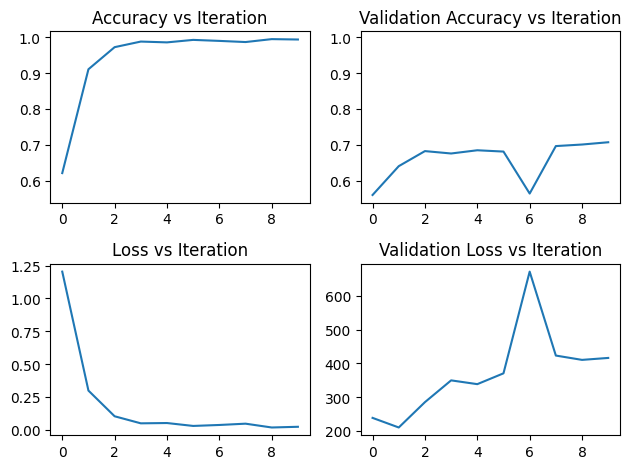

In [22]:
fig, axs = plt.subplots(2,2)

# Create accuracy plot
axs[0][0].plot(history.history['accuracy'])
axs[0][0].set_title("Accuracy vs Iteration")

# Create Validation Accuracy plot
axs[0][1].plot(history.history['val_accuracy'])
axs[0][1].set_title("Validation Accuracy vs Iteration")

axs[0][1].get_shared_y_axes().join(axs[0][1], axs[0][0])

# Create loss plot
axs[1][0].plot(history.history['loss'])
axs[1][0].set_title("Loss vs Iteration")

# Create Validation loss plot
axs[1][1].plot(history.history['val_loss'])
axs[1][1].set_title("Validation Loss vs Iteration")

fig.tight_layout()